# Modeling Vaccination Behavior

Below is the work that was done to produce a predictive model of vaccination behavior based on features from the 2009 H1N1 Flu Survey. This project is for Phase 3 of Flatiron School's Data Science Bootcamp.

Data was sourced from here:https://www.drivendata.org/competitions/66/flu-shot-learning/page/210/

Bull Peter, Slavitt Isaac, Lipstein Greg. 2016. Harnessing the Power of the Crowd to Increase Capacity for Data Science in the Social Sector. Presented at 2016 ICML Workshop on #Data4Good: Machine Learning in Social Good Applications, New York, NY. https://doi.org/10.48550/arXiv.1606.07781

Workflow Outline for Modeling:

Data: DHHS 2009 Flu Vaccine Survey --> ETL via Pipeline --> Random Forest modeling on encoded survey responses --> Naive Bayes modeling on Demographic information --> Stack Models to create final aggregate model --> Perform grid search to fine tune hyperparameters and iterate on initial model --> *perform boosting if time allows

Report on final metrics, primarily ROC curve AUC score; additionally accuracy, F1, confusion matrix; possibly precision/recall if relevant

### EDA

First step is to explore the data and find out what issues need to be addressed in order to train a model on this data.

importing necessary packages below:

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
#inputs
features = pd.read_csv("data/training_set_features.csv")

In [6]:
#targets
labels = pd.read_csv("data/training_set_labels.csv")

In [7]:
#looking at format of targets
labels.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [8]:
#ensuring no duplicates
full_stack = pd.merge(features, labels, on='respondent_id')

In [9]:
full_stack

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0,0
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,0,1
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,0,0


In [10]:
#performing train-test split to prevent data leakage
train, test = train_test_split(full_stack, random_state=42)

In [11]:
len(test)

6677

In [12]:
len(train)

20030

In [13]:
#saving test data for later use
test.to_csv('./data/test_data.csv')

In [14]:
#checking nulls
train.isna().sum()

respondent_id                      0
h1n1_concern                      67
h1n1_knowledge                    87
behavioral_antiviral_meds         56
behavioral_avoidance             157
behavioral_face_mask              14
behavioral_wash_hands             36
behavioral_large_gatherings       70
behavioral_outside_home           58
behavioral_touch_face             98
doctor_recc_h1n1                1635
doctor_recc_seasonal            1635
chronic_med_condition            717
child_under_6_months             605
health_worker                    597
health_insurance                9233
opinion_h1n1_vacc_effective      299
opinion_h1n1_risk                292
opinion_h1n1_sick_from_vacc      301
opinion_seas_vacc_effective      349
opinion_seas_risk                387
opinion_seas_sick_from_vacc      407
age_group                          0
education                       1040
race                               0
sex                                0
income_poverty                  3269
m

In [15]:
#looking at types of data (i.e. categorical, ordinal, discrete, scalar, numerical, etc.)
train['education'].value_counts()

College Graduate    7564
Some College        5318
12 Years            4348
< 12 Years          1760
Name: education, dtype: int64

In [16]:
train['income_poverty'].value_counts()

<= $75,000, Above Poverty    9671
> $75,000                    5095
Below Poverty                1995
Name: income_poverty, dtype: int64

In [17]:
train['marital_status'].value_counts()

Married        10222
Not Married     8770
Name: marital_status, dtype: int64

In [18]:
train['sex'].value_counts()

Female    11945
Male       8085
Name: sex, dtype: int64

In [19]:
train['age_group'].value_counts()

65+ Years        5129
55 - 64 Years    4198
18 - 34 Years    3948
45 - 54 Years    3891
35 - 44 Years    2864
Name: age_group, dtype: int64

<AxesSubplot:xlabel='age_group', ylabel='Count'>

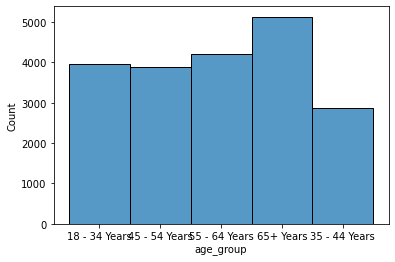

In [20]:
sns.histplot(train['age_group'])

<AxesSubplot:xlabel='opinion_h1n1_vacc_effective', ylabel='Count'>

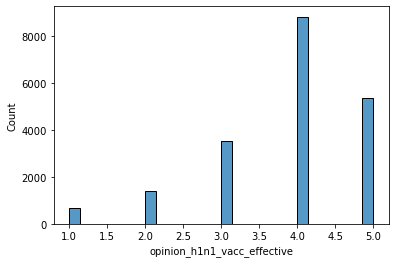

In [21]:
sns.histplot(train['opinion_h1n1_vacc_effective'])

In [22]:
#saving training data
train.to_csv("./data/training_data.csv")

# Pipeline

In [23]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

In [24]:
!ls data

submission_format.csv
test_data.csv
test_set_features.csv
training_data.csv
training_set_features.csv
training_set_labels.csv


Load in training data for initial ETL:

In [25]:
#import training data
train = pd.read_csv("./data/training_data.csv")
train

,Unnamed: 0,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,25194,25194,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,1.0,1.0,NaN,NaN,0,0
1,14006,14006,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,NaN,Employed,lzgpxyit,"MSA, Not Principle City",2.0,1.0,fcxhlnwr,oijqvulv,0,1
2,11285,11285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,kbazzjca,"MSA, Principle City",0.0,1.0,wlfvacwt,hfxkjkmi,0,1
3,2900,2900,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,mlyzmhmf,"MSA, Not Principle City",0.0,0.0,mcubkhph,ukymxvdu,0,0
4,19083,19083,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,NaN,NaN,bhuqouqj,"MSA, Not Principle City",NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20025,21575,21575,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,Own,Not in Labor Force,qufhixun,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
20026,5390,5390,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,Own,Unemployed,mlyzmhmf,"MSA, Principle City",0.0,0.0,NaN,NaN,0,0
20027,860,860,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,Non-MSA,1.0,0.0,atmlpfrs,xqwwgdyp,0,0
20028,15795,15795,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,Own,Employed,kbazzjca,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0,0


In [26]:
#remove unnamed:0 becuase its a duplicate of respondent_id
train = train.drop(labels="Unnamed: 0", axis=1)

In [27]:
train

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,25194,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,1.0,1.0,NaN,NaN,0,0
1,14006,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,NaN,Employed,lzgpxyit,"MSA, Not Principle City",2.0,1.0,fcxhlnwr,oijqvulv,0,1
2,11285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,kbazzjca,"MSA, Principle City",0.0,1.0,wlfvacwt,hfxkjkmi,0,1
3,2900,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,mlyzmhmf,"MSA, Not Principle City",0.0,0.0,mcubkhph,ukymxvdu,0,0
4,19083,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,bhuqouqj,"MSA, Not Principle City",NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20025,21575,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,Own,Not in Labor Force,qufhixun,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
20026,5390,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,Own,Unemployed,mlyzmhmf,"MSA, Principle City",0.0,0.0,NaN,NaN,0,0
20027,860,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,Own,Employed,qufhixun,Non-MSA,1.0,0.0,atmlpfrs,xqwwgdyp,0,0
20028,15795,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Own,Employed,kbazzjca,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,0,0


In [28]:
#split training set into target and features, drop secondary target and id
x_train = train.drop(labels=["respondent_id","h1n1_vaccine","seasonal_vaccine"], axis=1)
y_train = train["seasonal_vaccine"]

In [29]:
x_train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,1.0,1.0,NaN,NaN
1,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,Married,NaN,Employed,lzgpxyit,"MSA, Not Principle City",2.0,1.0,fcxhlnwr,oijqvulv
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,kbazzjca,"MSA, Principle City",0.0,1.0,wlfvacwt,hfxkjkmi
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Own,Employed,mlyzmhmf,"MSA, Not Principle City",0.0,0.0,mcubkhph,ukymxvdu
4,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,bhuqouqj,"MSA, Not Principle City",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20025,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Own,Not in Labor Force,qufhixun,"MSA, Principle City",0.0,0.0,NaN,NaN
20026,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Unemployed,mlyzmhmf,"MSA, Principle City",0.0,0.0,NaN,NaN
20027,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,Non-MSA,1.0,0.0,atmlpfrs,xqwwgdyp
20028,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,"> $75,000",Married,Own,Employed,kbazzjca,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea


In [30]:
y_train

0        0
1        1
2        1
3        0
4        1
        ..
20025    1
20026    0
20027    0
20028    0
20029    0
Name: seasonal_vaccine, Length: 20030, dtype: int64

Begin Pipeline Construction

In [31]:
x_train.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [32]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20030 entries, 0 to 20029
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 19963 non-null  float64
 1   h1n1_knowledge               19943 non-null  float64
 2   behavioral_antiviral_meds    19974 non-null  float64
 3   behavioral_avoidance         19873 non-null  float64
 4   behavioral_face_mask         20016 non-null  float64
 5   behavioral_wash_hands        19994 non-null  float64
 6   behavioral_large_gatherings  19960 non-null  float64
 7   behavioral_outside_home      19972 non-null  float64
 8   behavioral_touch_face        19932 non-null  float64
 9   doctor_recc_h1n1             18395 non-null  float64
 10  doctor_recc_seasonal         18395 non-null  float64
 11  chronic_med_condition        19313 non-null  float64
 12  child_under_6_months         19425 non-null  float64
 13  health_worker   

In [33]:
#labels

#already encoded in survey responses ordinally, values generally range from 0 to 5
ordinal_feat = ["h1n1_concern","h1n1_knowledge",'opinion_h1n1_vacc_effective','opinion_h1n1_risk',
                'opinion_h1n1_sick_from_vacc','opinion_seas_vacc_effective','opinion_seas_risk',
                'opinion_seas_sick_from_vacc','household_adults','household_children']
#features that are ordinal in nature, but are recorded as strings
ordinal_e_feat = ["age_group", "education"]
#categorical and binary features recorded in the dataset. Nulls represent "prefer not to answer"- 
#-type responses in compliance with human subjects research ethics requirements. Thus, all binary 
#features are now categorical to account for trends in refusal behavior in the model.
cat_feat = ['behavioral_antiviral_meds', 'behavioral_avoidance',
           'behavioral_face_mask', 'behavioral_wash_hands',
           'behavioral_large_gatherings', 'behavioral_outside_home',
           'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
           'chronic_med_condition', 'child_under_6_months', 'health_worker',
           'health_insurance', 'race', 'sex', 'income_poverty', 'marital_status',
           'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry',
           'employment_occupation']

In [34]:
#subpipelines
ordinal_impute = Pipeline(steps=[('impute', SimpleImputer(strategy="most_frequent"))])
ordinal_encoding = Pipeline(steps=[('impute', SimpleImputer(strategy="most_frequent")),
                                  ("ord_encode", OrdinalEncoder())
                                  ])
#mapping binary values to yes/no to resolve errors with one_hot_encoder
def mapper(data):
    data = data.applymap(lambda x: "yes" if (x==1) else x or "no" if (x==0) else x)
    data.astype(str)
    return data
mappy = FunctionTransformer(func=mapper)

one_hot_encoder = Pipeline(steps=[("map_bin", mappy),
                                  ('impute', SimpleImputer(strategy="constant",fill_value="no_response")),
                                  ("ohe", OneHotEncoder(sparse=False, handle_unknown="ignore"))
                                 ])


In [35]:
#columntransformer
col_tr = ColumnTransformer(transformers=[("ord_imp", ordinal_impute, ordinal_feat), 
                                         ("ord_enc", ordinal_encoding, ordinal_e_feat),
                                         ("imp_ohe", one_hot_encoder, cat_feat)],
                          sparse_threshold=0)

### Construct Initial Model

Initial model will be a voting classifier composed of a random forest estimator and a naive bayes estimator. A grid search will then be performed to find the best hyperparameters for each base estimator as well as the overall weights of the voting classifier. 

In [36]:
#import estimators
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, classification_report

In [37]:
#instantiate base estimators
rfc = RandomForestClassifier()
cat_nb = CategoricalNB()

In [38]:
#instantiate meta classifier
vc = VotingClassifier(estimators=[("rfc", rfc),
                                 ("cat_nb", cat_nb)],
                     voting="soft")

In [39]:
#setup basic initial model with default parameters
initial_model = Pipeline(steps=[("col_tr", col_tr),
                   ("vc", vc)])
initial_model.fit(x_train,y_train)

Pipeline(steps=[('col_tr',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('ord_imp',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'opinion_h1n1_vacc_effective',
                                                   'opinion_h1n1_risk',
                                                   'opinion_h1n1_sick_from_vacc',
                                                   'opinion_seas_vacc_effective',
                                                   'opinion_seas_risk',
                                                   'opinion_seas_sick_from_vacc',...
                                                   'chroni

In [40]:
#assessing initial model accuracy (cross validation)
cross_val_score(estimator=initial_model, X=x_train,y=y_train)

array([0.75786321, 0.74038942, 0.76035946, 0.74488268, 0.75436845])

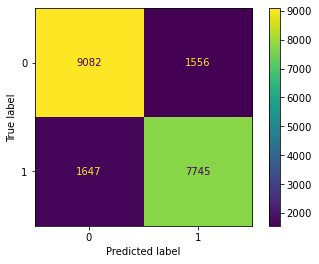

In [41]:
#training scores
plot_confusion_matrix(initial_model, X=x_train, y_true=y_train);

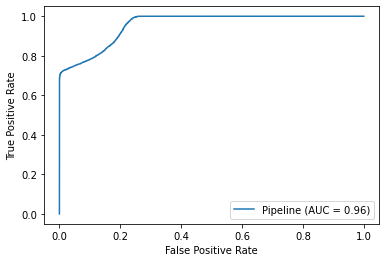

In [42]:
#training scores
plot_roc_curve(initial_model, X=x_train, y=y_train);

### Fine Tuning Our Predictive Model with Grid Search

In [43]:
#grid of testing hyperparameters
grid = {"vc__rfc__n_estimators": [650,700,750,800,850], 
        "vc__rfc__max_depth": [30,40,50,60,70],
        "vc__cat_nb__alpha": [0.5, 1, 1.5, 2, 2.5],
        "vc__cat_nb__fit_prior": [True,False],
        "vc__weights": [[.5,.5],[.6,.4],[.7,.3],[.8,.2],[.9,.1]]}

In [44]:
gs= GridSearchCV(initial_model, grid, verbose=3, n_jobs=-2)

In [45]:
gs.fit(x_train, y_train)

Fitting 5 folds for each of 1250 candidates, totalling 6250 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-2)]: Done 498 tasks      | elapsed: 110.5min
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed: 290.3min
[Parallel(n_jobs=-2)]: Done 1138 tasks      | elapsed: 494.7min
[Parallel(n_jobs=-2)]: Done 1554 tasks      | elapsed: 542.4min
[Parallel(n_jobs=-2)]: Done 2034 tasks      | elapsed: 586.5min
[Parallel(n_jobs=-2)]: Done 2578 tasks      | elapsed: 629.5min
[Parallel(n_jobs=-2)]: Done 3186 tasks      | elapsed: 686.9min
[Parallel(n_jobs=-2)]: Done 3858 tasks      | elapsed: 748.6min
[Parallel(n_jobs=-2)]: Done 4594 tasks      | elapsed: 807.0min
[Parallel(n_jobs=-2)]: Done 5394 tasks      | elapsed: 873.2min
[Parallel(n_jobs=-2)]: Done 6250 out of 6250 | elapsed: 948.7min finished


GridSearchCV(estimator=Pipeline(steps=[('col_tr',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('ord_imp',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['h1n1_concern',
                                                                          'h1n1_knowledge',
                                                                          'opinion_h1n1_vacc_effective',
                                                                          'opinion_h1n1_risk',
                                                                          'opinion_h1n1_sick_from_vacc',
                                                                   

In [46]:
gs.best_estimator_

Pipeline(steps=[('col_tr',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('ord_imp',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'opinion_h1n1_vacc_effective',
                                                   'opinion_h1n1_risk',
                                                   'opinion_h1n1_sick_from_vacc',
                                                   'opinion_seas_vacc_effective',
                                                   'opinion_seas_risk',
                                                   'opinion_seas_sick_from_vacc',...
                                                   'health

In [47]:
gs.best_params_

{'vc__cat_nb__alpha': 0.5,
 'vc__cat_nb__fit_prior': True,
 'vc__rfc__max_depth': 60,
 'vc__rfc__n_estimators': 650,
 'vc__weights': [0.9, 0.1]}

In [48]:
gs.best_score_

0.7776335496754868

### Evaluating the Final Model

In [49]:
#saving our most accurate model from the grid searching step as our final model
import pickle
pickle.dump(gs.best_estimator_, open('Final_Model.pkl', 'wb'))
Final_Model = pickle.load(open('Final_Model.pkl', 'rb'))

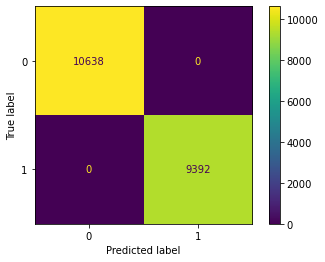

In [50]:
#evaluating cross-validation scores and pre-testing results
plot_confusion_matrix(Final_Model, X=x_train, y_true=y_train);

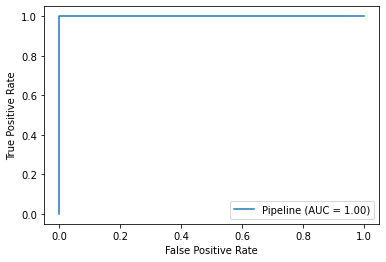

In [51]:
plot_roc_curve(Final_Model, X=x_train, y=y_train);

Based on the training results, there are a lot of indications that the model is overfit. The next step is to import the testing data and perform a final test on unseen data, which, will be conducted using for both the initial and final models due to this concern. If the final model is too overfit and performs worse on testing data compared to the initial model, then it will be replaced with the initial model as the model delivered to stakeholders.

### Final Evaluation

In [52]:
#import testing data
!ls data

submission_format.csv
test_data.csv
test_set_features.csv
training_data.csv
training_set_features.csv
training_set_labels.csv


In [53]:
test = pd.read_csv("./data/test_data.csv")
test

,Unnamed: 0,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,15772,15772,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,atmpeygn,"MSA, Principle City",NaN,NaN,NaN,NaN,0,0
1,9407,9407,3.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,fpwskwrf,"MSA, Principle City",1.0,1.0,NaN,NaN,0,1
2,16515,16515,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,Own,Employed,atmpeygn,"MSA, Not Principle City",0.0,1.0,mfikgejo,mxkfnird,0,0
3,23353,23353,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,...,Own,Employed,bhuqouqj,Non-MSA,1.0,2.0,cfqqtusy,xtkaffoo,0,0
4,10008,10008,1.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Own,Employed,lrircsnp,"MSA, Principle City",1.0,0.0,wxleyezf,xtkaffoo,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6672,25990,25990,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Rent,Employed,oxchjgsf,Non-MSA,1.0,0.0,ldnlellj,hodpvpew,0,0
6673,14302,14302,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,...,Own,Employed,lrircsnp,"MSA, Principle City",1.0,0.0,mcubkhph,ukymxvdu,0,0
6674,3817,3817,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,...,Own,Employed,bhuqouqj,"MSA, Principle City",1.0,0.0,wlfvacwt,xtkaffoo,1,1
6675,13912,13912,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,Own,Employed,bhuqouqj,"MSA, Not Principle City",1.0,1.0,mfikgejo,mxkfnird,0,0


In [54]:
#split testing set into target and features
x_test = test.drop(labels=["Unnamed: 0","respondent_id","h1n1_vaccine","seasonal_vaccine"], axis=1)
y_test = test["seasonal_vaccine"]

In [55]:
#Final Model classification report
print(classification_report(y_test, Final_Model.predict(X=x_test)))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      3634
           1       0.77      0.76      0.76      3043

    accuracy                           0.79      6677
   macro avg       0.78      0.78      0.78      6677
weighted avg       0.79      0.79      0.79      6677



In [56]:
#initial model classification report
print(classification_report(y_test, initial_model.predict(X=x_test)))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      3634
           1       0.74      0.73      0.74      3043

    accuracy                           0.76      6677
   macro avg       0.76      0.76      0.76      6677
weighted avg       0.76      0.76      0.76      6677



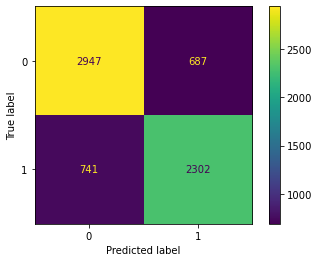

In [57]:
#final model confusion matrix
plot_confusion_matrix(Final_Model, x_test, y_test);

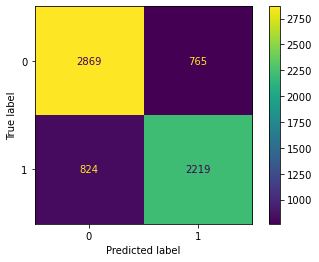

In [58]:
#initial model confusion matrix
plot_confusion_matrix(initial_model, x_test, y_test);

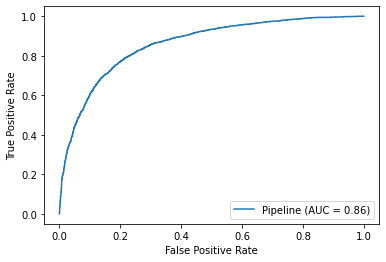

In [59]:
#final model roc-auc
plot_roc_curve(Final_Model, x_test, y_test);

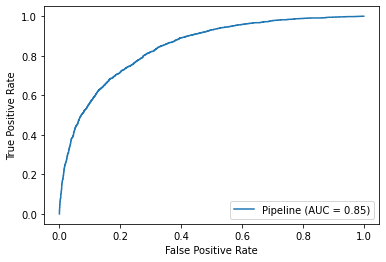

In [60]:
#initial model roc_auc
plot_roc_curve(initial_model, x_test, y_test);

Dummy model for baseline comparison:

In [61]:
from sklearn.dummy import DummyClassifier

In [62]:
dum_dum = DummyClassifier(strategy="most_frequent")

In [63]:
dum_dum.fit(X=x_train, y=y_train)

DummyClassifier(strategy='most_frequent')

In [64]:
print(classification_report(y_test, dum_dum.predict(x_test)))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70      3634
           1       0.00      0.00      0.00      3043

    accuracy                           0.54      6677
   macro avg       0.27      0.50      0.35      6677
weighted avg       0.30      0.54      0.38      6677



C:\Users\ninja\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


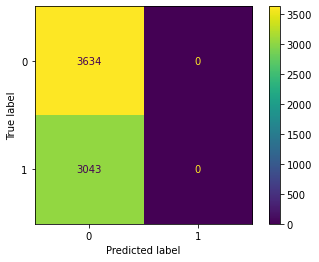

In [65]:
plot_confusion_matrix(dum_dum, x_test, y_test);

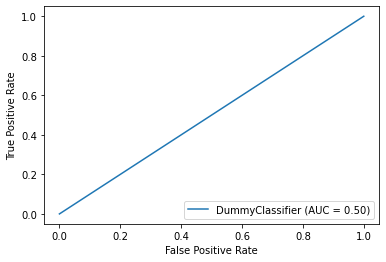

In [66]:
plot_roc_curve(dum_dum, x_test, y_test);